In [1]:
import pandas as pd
import numpy as np

import os
import time
from tqdm import tqdm
from pathlib import Path
import math

from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torchsummary import summary
from torch.optim.lr_scheduler import _LRScheduler
from torch import nn
from torch.utils.data import Dataset
from torchvision import transforms as T
import nibabel as nib
from skimage.transform import resize

import random

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(0)

In [2]:
# Model define
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv3d) or isinstance(m, nn.Linear):
            nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
            
# Define 3D_CNN model class

class CNN(nn.Module):
    def __init__(self, in_channels):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv3d(in_channels, 32, kernel_size=(3,3,3), padding=1),
            nn.ReLU(),
            nn.BatchNorm3d(32),
            nn.Conv3d(32, 32, kernel_size=(3,3,3), padding=1),
            nn.ReLU(),
            nn.Dropout3d(0.2),
            nn.MaxPool3d(kernel_size=(2,2,2))
        )

        self.conv2 = nn.Sequential(
            nn.Conv3d(32, 64, kernel_size=(3,3,3), stride=1, padding="same"),
            nn.ReLU(),
            nn.BatchNorm3d(64),
            nn.Conv3d(64, 64, kernel_size=(3,3,3), stride=1, padding="same"),
            nn.ReLU(),
            nn.Dropout3d(0.2),
            nn.MaxPool3d(kernel_size=(2,2,2))
        )

        self.conv3 = nn.Sequential(
            nn.Conv3d(64, 64, kernel_size=(3,3,3), stride=1, padding="same"),
            nn.ReLU(),
            nn.BatchNorm3d(64),
            nn.Conv3d(64, 64, kernel_size=(3,3,3), stride=1, padding="same"),
            nn.ReLU(),
            nn.BatchNorm3d(64),
            nn.MaxPool3d(2)
        )

        self.conv4 = nn.Sequential(
            nn.Conv3d(64, 64, kernel_size=(3,3,3), stride=1, padding="same"),
            nn.ReLU(),
            nn.BatchNorm3d(64),
            nn.Conv3d(64, 64, kernel_size=(3,3,3), stride=1, padding="same"),
            nn.ReLU(),
            nn.BatchNorm3d(64),
            nn.Conv3d(64, 64, kernel_size=(3,3,3), stride=1, padding="same"),
            nn.ReLU(),
            nn.BatchNorm3d(64),
            nn.MaxPool3d(2)
        )

        self.conv5 = nn.Sequential(
            nn.Conv3d(64, 96, kernel_size=(3,3,3), stride=1, padding="same"),
            nn.ReLU(),
            nn.BatchNorm3d(96),
            nn.Conv3d(96, 96, kernel_size=(3,3,3), stride=1, padding="same"),
            nn.ReLU(),
            nn.BatchNorm3d(96),
            nn.Conv3d(96, 96, kernel_size=(3,3,3), stride=1, padding="same"),
            nn.ReLU(),
            nn.BatchNorm3d(96),
            nn.MaxPool3d(2)
        )

        self.conv6 = nn.Sequential(
            nn.Conv3d(96, 96, kernel_size=(3,3,3), stride=1, padding="same"),
            nn.ReLU(),
            nn.BatchNorm3d(96),
            nn.Conv3d(96, 96, kernel_size=(3,3,3), stride=1, padding="same"),
            nn.ReLU(),
            nn.BatchNorm3d(96),
            nn.Conv3d(96, 96, kernel_size=(3,3,3), stride=1, padding="same"),
            nn.ReLU(),
            nn.BatchNorm3d(96),
            nn.MaxPool3d(2)
        )

        self.conv7 = nn.Sequential(
            nn.Conv3d(96, 96, kernel_size=(3,3,3), stride=1, padding="same"),
            nn.ReLU(),
            nn.BatchNorm3d(96),
            nn.Conv3d(96, 96, kernel_size=(3,3,3), stride=1, padding="same"),
            nn.ReLU(),
            nn.BatchNorm3d(96),
            nn.Conv3d(96, 96, kernel_size=(3,3,3), stride=1, padding="same"),
            nn.ReLU(),
            nn.BatchNorm3d(96)
        )
        
        self.flatten = nn.Flatten()

        self.fc = nn.Sequential(
            nn.Linear(768, 96),
            nn.ReLU(),
            nn.Linear(96, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
            
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

In [3]:
class CustomCosineAnnealingWarmUpRestarts(_LRScheduler):
    def __init__(self, optimizer, T_0, T_mult=1, eta_max=0.1, T_up=0, gamma=1., last_epoch=-1):
        if T_0 <= 0 or not isinstance(T_0, int):
            raise ValueError("Expected positive integer T_0, but got {}".format(T_0))
        if T_mult < 1 or not isinstance(T_mult, int):
            raise ValueError("Expected integer T_mult >= 1, but got {}".format(T_mult))
        if T_up < 0 or not isinstance(T_up, int):
            raise ValueError("Expected positive integer T_up, but got {}".format(T_up))
        self.T_0 = T_0
        self.T_mult = T_mult
        self.base_eta_max = eta_max
        self.eta_max = eta_max
        self.T_up = T_up
        self.T_i = T_0
        self.gamma = gamma
        self.cycle = 0
        self.T_cur = last_epoch
        super(CustomCosineAnnealingWarmUpRestarts, self).__init__(optimizer, last_epoch)
    
    def get_lr(self):
        if self.T_cur == -1:
            return self.base_lrs
        elif self.T_cur < self.T_up:
            return [(self.eta_max - base_lr)*self.T_cur / self.T_up + base_lr for base_lr in self.base_lrs]
        else:
            return [base_lr + (self.eta_max - base_lr) * (1 + math.cos(math.pi * (self.T_cur-self.T_up) / (self.T_i - self.T_up))) / 2
                    for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.T_cur = self.T_cur + 1
            if self.T_cur >= self.T_i:
                self.cycle += 1
                self.T_cur = self.T_cur - self.T_i
                self.T_i = (self.T_i - self.T_up) * self.T_mult + self.T_up
        else:
            if epoch >= self.T_0:
                if self.T_mult == 1:
                    self.T_cur = epoch % self.T_0
                    self.cycle = epoch // self.T_0
                else:
                    n = int(math.log((epoch / self.T_0 * (self.T_mult - 1) + 1), self.T_mult))
                    self.cycle = n
                    self.T_cur = epoch - self.T_0 * (self.T_mult ** n - 1) / (self.T_mult - 1)
                    self.T_i = self.T_0 * self.T_mult ** (n)
            else:
                self.T_i = self.T_0
                self.T_cur = epoch
                
        self.eta_max = self.base_eta_max * (self.gamma**self.cycle)
        self.last_epoch = math.floor(epoch)
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

In [4]:
# Define trainer
class CNN_Trainer():
    def __init__(
            self, 
            model, 
            results_folder, 
            dataloader_train, 
            dataloader_valid, 
            dataloader_test, 
            epochs, 
            optimizer,
            scheduler,
            n_iter):
        super(CNN_Trainer, self).__init__()

        self.model = model
        self.dataloader_train = dataloader_train
        self.dataloader_valid = dataloader_valid
        self.dataloader_test = dataloader_test
        self.epoch = 0
        self.epochs = epochs
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.mse_loss_fn = nn.MSELoss()
        self.mae_loss_fn = nn.L1Loss()

        self.cv_num = n_iter
        self.results_folder = Path(results_folder)
        self.results_folder.mkdir(exist_ok=True)

        self.train_mse_list, self.train_mae_list = [], []
        self.valid_mse_list, self.valid_mae_list = [], []
        self.output_array, self.target_array = np.array([]), np.array([])

#         wandb.watch(self.model, log="all")

    def train(self):
        print("[ Start ]")
        
        latest_model_path = sorted(self.results_folder.glob(f'cv-{self.cv_num}-*.pth.tar'), 
                                key=lambda x: int(x.stem.split('-')[2].split('.')[0]))
        if latest_model_path:
            # Parse the filename to get the epoch number
            latest_epoch_num = int(latest_model_path[-1].stem.split('-')[2].split('.')[0]) - 1
            # Load the model
            self.load(latest_epoch_num)
            # Update self.epoch
            self.epoch = latest_epoch_num + 1
            
            if self.valid_mae_list:
                valid_loss_min = self.valid_mse_list[-1]
            else:
                valid_loss_min = 10000
            
            print(f"Loaded model: {latest_model_path[-1]}, Starting from epoch: {self.epoch} / {self.epochs}")


        self.model.train()
        
        start = time.time()  # Start time
        while self.epoch < self.epochs:
            print(f"\nEpoch {self.epoch+1:3d}: training")
            train_mse_sum, train_mae_sum = 0, 0
            for batch_ID, (input, target) in enumerate(tqdm(self.dataloader_train)):
                input = input.cuda(non_blocking=True)
                target = target.reshape(-1, 1)
                target = target.cuda(non_blocking=True)
                
                output = self.model(input)
                
                # ----------- update -----------
                self.optimizer.zero_grad()

                mse_loss = self.mse_loss_fn(output, target)
                mae_loss = self.mae_loss_fn(output, target)
                
                mse_loss.backward() # loss_fn should be the one used for backpropagation
                self.optimizer.step()
                self.scheduler.step()
                
#                 wandb.log({
#                 "Learning rate": self.optimizer.param_groups[0]['lr'],
#                 })

                train_mse_sum += mse_loss.item()*input.size(0)
                train_mae_sum += mae_loss.item()*input.size(0)

            train_mse_avg = train_mse_sum / len(self.dataloader_train.dataset)
            train_mae_avg = train_mae_sum / len(self.dataloader_train.dataset)

            self.train_mse_list.append(train_mse_avg)
            self.train_mae_list.append(train_mae_avg)
            
#             wandb.log({
#                 "Epoch": self.epoch+1,
#                 "Learning rate": self.optimizer.param_groups[0]['lr'],
#                 "Train MSE Loss": train_mse_avg,
#                 "Train MAE Loss": train_mae_avg,
#                 "CV Split Number": self.cv_num
#             })
            
            end = time.time()  # End time
            # Compute the duration and GPU usage
            duration = (end - start) / 60
            print(f"Epoch: {self.epoch+1}, duration for training: {duration:.2f} minutes")

            # validation step
            print(f"\nEpoch {self.epoch+1:3d}: validation")
            start = time.time()  # Start time
            self.model.eval()
            with torch.no_grad():
                valid_mse_sum, valid_mae_sum = 0, 0
                for _, (input, target) in enumerate(tqdm(self.dataloader_valid)):
                    input = input.cuda(non_blocking=True)
                    target = target.reshape(-1, 1)
                    target = target.cuda(non_blocking=True)

                    output = self.model(input)

                    mse_loss = self.mse_loss_fn(output, target) 
                    mae_loss = self.mae_loss_fn(output, target)

                    valid_mse_sum += mse_loss.item()*input.size(0) # mse_loss.item() * input.size(0): 각 배치에서의 총 손실을 계산
                                                                   # input.size(0): 배치 내의 샘플 수를 반환, 이것을 MSE 손실 값에 곱하면 해당 배치의 전체 손실
                                                                   # validation set의 모든 배치를 통해 계산된 총 손실을 더하여 합산
                    valid_mae_sum += mae_loss.item()*input.size(0)

                valid_mse_avg = valid_mse_sum / len(self.dataloader_valid.dataset)
                valid_mae_avg = valid_mae_sum / len(self.dataloader_valid.dataset)

                self.valid_mse_list.append(valid_mse_avg)
                self.valid_mae_list.append(valid_mae_avg)
                
                self.scheduler.step(valid_mse_avg)
                print(f"    Epoch {self.epoch+1:2d}: training mse loss = {train_mse_avg:.3f} / validation mse loss = {valid_mse_avg:.3f}")
                print(f"    Epoch {self.epoch+1:2d}: training mae loss = {train_mae_avg:.3f} / validation mae loss = {valid_mae_avg:.3f}")
                
                self.save(self.epoch)

                # # Print model if better validation loss
                # if valid_mse_avg < valid_loss_min:
                #     print(">>>>>>>>>>>>>>>>>> Loss updates")
                #     valid_loss_min = valid_mse_avg
                #     print(f"    Best Saved model: best-{self.results_folder}-{self.epoch+1}.pth.tar")
                    
#                 wandb.log({
#                     "Epoch": self.epoch+1,
#                     "Learning rate": self.optimizer.param_groups[0]['lr'],
#                     "Validation MSE Loss": valid_mse_avg,
#                     "Validation MAE Loss": valid_mae_avg
#                 })
                
            self.epoch += 1
            
        print("[ End of Epoch ]")
        end = time.time()  # End time
        # Compute the duration and GPU usage
        duration = (end - start) / 60
        print(f"Epoch: {self.epoch}, duration for validation: {duration:.2f} minutes")
        
        return self.train_mse_list, self.train_mae_list, self.valid_mse_list, self.valid_mae_list
    
    
    def test(self):
        print("[ Start test ]")
        self.model.eval()
        output_array = np.array([])
        target_array = np.array([])
        with torch.no_grad():
            test_mse_sum, test_mae_sum = 0, 0
            for _, (input, target) in enumerate(tqdm(self.dataloader_test)):
                input = input.cuda(non_blocking=True)
                target = target.reshape(-1, 1)
                target = target.cuda(non_blocking=True)

                output = self.model(input)

                output_array = np.append(output_array, output.cpu().numpy())
                target_array = np.append(target_array, target.cpu().numpy())

                mse_loss = self.mse_loss_fn(output, target) 
                mae_loss = self.mae_loss_fn(output, target)

                test_mse_sum += mse_loss.item()*input.size(0)
                test_mae_sum += mae_loss.item()*input.size(0)

            test_mse_avg = test_mse_sum / len(self.dataloader_test.dataset)
            test_mae_avg = test_mae_sum / len(self.dataloader_test.dataset)

            print(f"test mse loss = {test_mse_avg:.3f} / test mae loss = {test_mae_avg:.3f}")

        print("[ End test ]")
        return output_array, target_array


#             wandb.log({
#                 "Test MSE Loss": test_mse_avg,
#                 "Test MAE Loss": test_mae_avg
#             })
            
        print("[ End test ]")
        return test_mse_avg, test_mae_avg
    
    def save(self, milestone):
        torch.save({"epoch": milestone+1, 
                    "state_dict": self.model.state_dict(), 
                    "optimizer" : self.optimizer.state_dict(),  
                    "train_mse_list": self.train_mse_list,
                    "train_mae_list": self.train_mae_list,
                    "valid_mse_list": self.valid_mse_list,
                    "valid_mae_list": self.valid_mae_list},  
                    f"{self.results_folder}/cv-{self.cv_num}-{milestone+1}.pth.tar")
        
#     def load(self, milestone):
#         checkpoint = torch.load(f"{self.results_folder}/cv-{self.cv_num}-{milestone+1}.pth.tar")
#         self.model.load_state_dict(checkpoint["state_dict"])
#         self.optimizer.load_state_dict(checkpoint["optimizer"])
#         self.epoch = checkpoint["epoch"] + 1  # Start the next epoch after the checkpoint
#         self.train_mse_list = checkpoint.get("train_mse_list", [])
#         self.train_mae_list = checkpoint.get("train_mae_list", [])
#         self.valid_mse_list = checkpoint.get("valid_mse_list", [])
#         self.valid_mae_list = checkpoint.get("valid_mae_list", [])
    
    def load(self, checkpoint):
        self.model.load_state_dict(checkpoint["state_dict"])
        self.optimizer.load_state_dict(checkpoint["optimizer"])
        self.epoch = checkpoint["epoch"]  # Get the epoch directly from the checkpoint
        self.train_mse_list = checkpoint.get("train_mse_list", [])
        self.train_mae_list = checkpoint.get("train_mae_list", [])
        self.valid_mse_list = checkpoint.get("valid_mse_list", [])
        self.valid_mae_list = checkpoint.get("valid_mae_list", [])



# Healthy samples

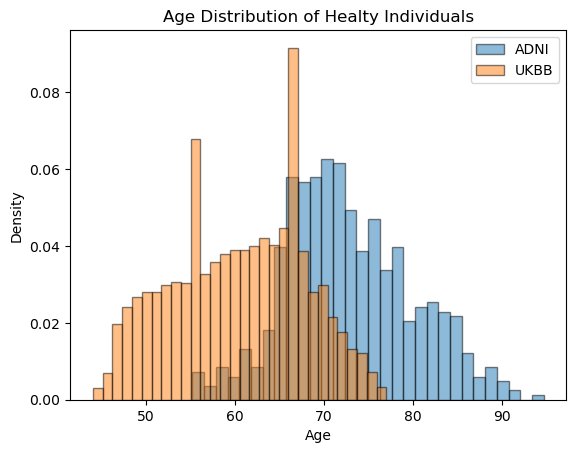

In [5]:
ukbb_pd = pd.read_csv('/media/leelabsg-storage1/yein/research/BrainAging/0722/csv/ukbb_cn.csv')
adni_pd = pd.read_csv('/media/leelabsg-storage1/yein/research/BrainAging/0722/csv/fsdat_baseline_cn.csv')

plt.hist(adni_pd['age'], bins=30, alpha=0.5, label='ADNI', density=True, edgecolor='black')
plt.hist(ukbb_pd['age'], bins=30, alpha=0.5, label='UKBB', density=True, edgecolor='black')

plt.title('Age Distribution of Healty Individuals')
plt.xlabel('Age')
plt.ylabel('Density')

plt.legend(loc='upper right')
plt.show()

In [69]:
print('ADNI Statistics:')
print(adni_pd['age'].describe())

ADNI Statistics:
count    630.000000
mean      72.764286
std        7.127740
min       55.200000
25%       67.600000
50%       71.750000
75%       77.450000
max       94.700000
Name: age, dtype: float64


In [70]:
print('\nUKBB Statistics:')
print(ukbb_pd['age'].describe())


UKBB Statistics:
count    25656.000000
mean        60.416004
std          7.382716
min         44.000000
25%         54.750000
50%         61.000000
75%         66.000000
max         77.000000
Name: age, dtype: float64


In [7]:
class ADNI_Dataset(Dataset):
    def __init__(self, image_path, label_path, indices, image_size=128):
        super(ADNI_Dataset, self).__init__()
        self.data_dir = image_path
        self.data_csv = pd.read_csv(label_path)
        
        # Use 'file_name' column to create image paths
        self.files = self.data_csv.loc[indices, 'File_name'].tolist()
        print(f"Number of files loaded: {len(self.files)}")  # Add this line

        self.input_size = (1, 128, 128, 128)

    def __getitem__(self, index):
        # label = self.data_csv.loc[index, 'age']
        label = self.data_csv.loc[index, 'age']
        file_name = self.data_csv.loc[index, 'File_name']
#         print(f'Index: {index},   File name: {file_name},   Age: {label}')

        # Use 'file_name' to construct the image path
        image_path = os.path.join(self.data_dir, file_name, 'brain_to_MNI_nonlin.nii.gz')

        # Convert Nifti1Image to numpy array
        image = nib.load(image_path).get_fdata()

        # Resize the image to desired size if necessary
        image = resize(image, self.input_size)

        # Convert numpy array to PyTorch tensor
        image = torch.from_numpy(image).float()

        age = torch.tensor(label, dtype=torch.float32)
        
        return (image, age)
    
    def __len__(self):
        return len(self.files)

    def collate_fn(self, batch):
        images, labels = zip(*batch)  # separate images and labels
        images = torch.stack(images)  # stack images into a tensor
        labels = torch.tensor(labels)  # convert labels into a tensor
        return images, labels

In [8]:
DATA = '/media/leelabsg-storage1/DATA/ADNI/adni_t1s_baseline' 
LABEL = '/media/leelabsg-storage1/yein/research/BrainAging/0724_leelabgpu/csv/fsdat_baseline_cn.csv' 

ngpus = torch.cuda.device_count()
print("Number of gpus: ", ngpus)

# wandb.init(project='test')

# hypterparameters
BATCH_SIZE = 8
EPOCHS = 2
RESULTS_FOLDER = './test'
INPUT_SIZE = (1, 128, 128, 128)
LEARNING_RATE = 1e-6
N_WORKERS = 2


# create our k-folds
kf = KFold(n_splits=4, random_state=7, shuffle=True)
n_iter = 0

dataset_pd = pd.read_csv(LABEL)
# obtain the indices for our dataset
indices = list(range(len(dataset_pd)))
print(f"Total dataset indices: {len(indices)}")

# Data paths and hyperparameters
print("Age distribution: ", dataset_pd['age'].describe())


# --------------------------------------------------------------------------------------------------------------

# Initialize your model (Make sure it's the same architecture as the one you trained)
model = CNN(in_channels=1).cuda()  
# Put your model on the GPU
model = torch.nn.DataParallel(model)

# Define your optimizer and scheduler
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
t_0 = int(len(dataset_pd) * 0.75 // BATCH_SIZE // 6)
scheduler = CustomCosineAnnealingWarmUpRestarts(optimizer,T_0= t_0, T_up=10, T_mult=2, eta_max=1e-3, gamma=0.5)

# Loss function
mse_criterion = torch.nn.MSELoss()
mae_criterion = torch.nn.L1Loss()
    
test_indices = list(dataset_pd.index)

# Create test dataset
test_dataset = ADNI_Dataset(DATA, LABEL, test_indices)

# Create DataLoader for test set
dataloader_test = DataLoader(test_dataset, 
                             batch_size=1, 
                             sampler=SequentialSampler(test_dataset),
                             collate_fn=test_dataset.collate_fn,
                             pin_memory=True,
                             num_workers=2)
print(f"Length of test dataset: {len(dataloader_test.dataset)}")

Number of gpus:  2
Total dataset indices: 630
Age distribution:  count    630.000000
mean      72.764286
std        7.127740
min       55.200000
25%       67.600000
50%       71.750000
75%       77.450000
max       94.700000
Name: age, dtype: float64
Number of files loaded: 630
Length of test dataset: 630


In [9]:
# Load the checkpoints for the 17th and 40th epochs
checkpoint_17 = torch.load("/media/leelabsg-storage1/yein/research/BrainAging/0726_titan/model/esb_2/cv-0-17.pth.tar")
checkpoint_40 = torch.load("/media/leelabsg-storage1/yein/research/BrainAging/0726_titan/model/esb_2/cv-0-40.pth.tar")

In [10]:
# Initialize the trainer
trainer = CNN_Trainer(
    model=model, 
    results_folder=RESULTS_FOLDER,  # replace with the path where your results are saved
    dataloader_train=None,  # You don't need the training set for inference
    dataloader_valid=None,  # You don't need the validation set for inference
    dataloader_test=dataloader_test, 
    epochs=0,  # You don't need to specify epochs for inference
    optimizer=optimizer,
    scheduler=scheduler,
    n_iter=4  # replace with the appropriate iteration number
)

In [18]:
# Load the 17th epoch's model state and get its predictions
trainer.load(checkpoint_17)
predictions_17, targets = trainer.test()

[ Start test ]


100%|██████████| 630/630 [03:26<00:00,  3.05it/s]

test mse loss = 173.862 / test mae loss = 11.444
[ End test ]


In [19]:
# Load the 40th epoch's model state and get its predictions
trainer.load(checkpoint_40)
predictions_40, targets_40 = trainer.test()

[ Start test ]


100%|██████████| 630/630 [03:33<00:00,  2.95it/s]

test mse loss = 333.016 / test mae loss = 16.644
[ End test ]


In [20]:
from scipy.stats import pearsonr

# Compute Pearson correlation
correlation, _ = pearsonr(predictions_17, predictions_40)
print('Pearson correlation between 17th and 40th epoch models:', correlation)

Pearson correlation between 17th and 40th epoch models: -0.1413452862084732


### 두 모델의 예측 결과 간의 상관관계 계산

Pearson correlation between 17th and 40th epoch models: -0.1413452862084732


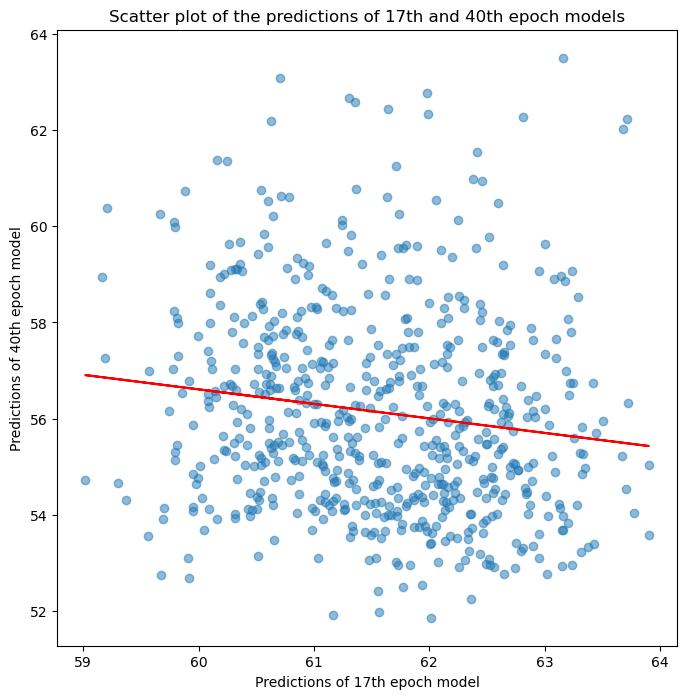

In [21]:
# Compute Pearson correlation
correlation, _ = pearsonr(predictions_17, predictions_40)
print('Pearson correlation between 17th and 40th epoch models:', correlation)

# Create scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(predictions_17, predictions_40, alpha=0.5)

# Fit a linear trend line
m, b = np.polyfit(predictions_17, predictions_40, 1)
plt.plot(predictions_17, m*predictions_17 + b, color='red')

plt.title('Scatter plot of the predictions of 17th and 40th epoch models')
plt.xlabel('Predictions of 17th epoch model')
plt.ylabel('Predictions of 40th epoch model')
plt.show()

### Mean 비교

In [35]:
print(f'Mean predicted age for 17-epoch model: {np.mean(predictions_17)}')
print(f'Mean predicted age for 40-epoch model: {np.mean(predictions_40)}')

Mean predicted age for 17-epoch model: 61.56927387298099
Mean predicted age for 40-epoch model: 56.13682188003782


In [36]:
print(f'Mean actual age for 17-epoch model: {np.mean(targets_17)}')
print(f'Mean actual age for 40-epoch model: {np.mean(target_40)}')

Mean actual age for 17-epoch model: 72.76428569006542
Mean actual age for 40-epoch model: 72.76428569006542
